In [1]:
import numpy as np 
import pandas as pd
import random
import keras
import torch
import tensorflow as tf
import optuna
from optuna import Trial
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import log_loss
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from sklearn import metrics
import os
from sklearn.utils import compute_sample_weight


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
SEED = 99
def random_seed(SEED):
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    tf.random.set_seed(SEED)
random_seed(SEED)

In [4]:
train_data1 = pd.read_json('primate_dataset.json')
train_data1.head()

,post_title,post_text,annotations
0,I don't feel original anymore.,"When I was in high school a few years back, I ...",[[Feeling-bad-about-yourself-or-that-you-are-a...
1,I don’t have anyone to talk to and I don’t kno...,Nine years ago I was diagnosed with depression...,[[Feeling-bad-about-yourself-or-that-you-are-a...
2,Stuck between moving forward and killing myself,Some background information: My GF of almost 3...,[[Feeling-bad-about-yourself-or-that-you-are-a...
3,I need help on how to help my girlfriend.,"My girlfriend ,of about 3 months now ,has been...",[[Feeling-bad-about-yourself-or-that-you-are-a...
4,I've been feeling this way for some tine,I'm alway feeling like this. It doesn't even m...,[[Feeling-bad-about-yourself-or-that-you-are-a...


In [5]:
train_data1['tags'] = train_data1['annotations'].apply(lambda x: [annotation[0] for annotation in x if annotation[1] == 'yes'])


In [6]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(train_data1['tags'])
y.shape

(2003, 9)

In [7]:
new_data = pd.DataFrame(y, columns=mlb.classes_)
train_data1 = pd.concat([train_data1, new_data], axis=1)
# Rename columns as tag1-tag9
new_columns = ['Tag' + str(i+1) for i in range(9)]
renaming_dict = dict(zip(train_data1.columns[4:], new_columns))
train_data1.rename(columns=renaming_dict, inplace=True)

# Print the renaming dictionary
print(renaming_dict)


{'Feeling-bad-about-yourself-or-that-you-are-a-failure-or-have-let-yourself-or-your-family-down': 'Tag1', 'Feeling-down-depressed-or-hopeless': 'Tag2', 'Feeling-tired-or-having-little-energy': 'Tag3', 'Little-interest-or-pleasure-in-doing ': 'Tag4', 'Moving-or-speaking-so-slowly-that-other-people-could-have-noticed-Or-the-opposite-being-so-fidgety-or-restless-that-you-have-been-moving-around-a-lot-more-than-usual': 'Tag5', 'Poor-appetite-or-overeating': 'Tag6', 'Thoughts-that-you-would-be-better-off-dead-or-of-hurting-yourself-in-some-way': 'Tag7', 'Trouble-concentrating-on-things-such-as-reading-the-newspaper-or-watching-television': 'Tag8', 'Trouble-falling-or-staying-asleep-or-sleeping-too-much': 'Tag9'}


In [8]:
train_data1.head()

,post_title,post_text,annotations,tags,Tag1,Tag2,Tag3,Tag4,Tag5,Tag6,Tag7,Tag8,Tag9
0,I don't feel original anymore.,"When I was in high school a few years back, I ...",[[Feeling-bad-about-yourself-or-that-you-are-a...,[Feeling-bad-about-yourself-or-that-you-are-a-...,1,0,1,1,0,0,0,0,0
1,I don’t have anyone to talk to and I don’t kno...,Nine years ago I was diagnosed with depression...,[[Feeling-bad-about-yourself-or-that-you-are-a...,[Feeling-bad-about-yourself-or-that-you-are-a-...,1,1,0,0,1,0,0,0,0
2,Stuck between moving forward and killing myself,Some background information: My GF of almost 3...,[[Feeling-bad-about-yourself-or-that-you-are-a...,[Feeling-bad-about-yourself-or-that-you-are-a-...,1,1,1,1,0,0,1,0,0
3,I need help on how to help my girlfriend.,"My girlfriend ,of about 3 months now ,has been...",[[Feeling-bad-about-yourself-or-that-you-are-a...,[Feeling-bad-about-yourself-or-that-you-are-a-...,1,1,0,0,0,0,1,0,0
4,I've been feeling this way for some tine,I'm alway feeling like this. It doesn't even m...,[[Feeling-bad-about-yourself-or-that-you-are-a...,[Feeling-bad-about-yourself-or-that-you-are-a-...,1,1,0,0,0,0,0,0,0


<Axes: >

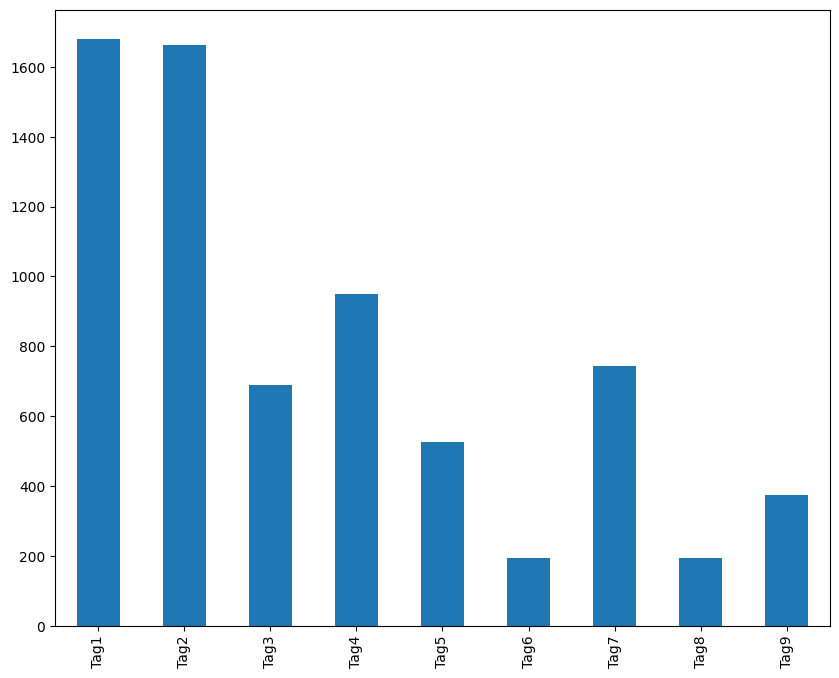

In [9]:
comments_labels = train_data1[['Tag1','Tag2','Tag3','Tag4','Tag5', 'Tag6', 'Tag7', 'Tag8', 'Tag9']]
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
comments_labels.sum(axis=0).plot.bar()

In [103]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

# Define a function to preprocess the text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Join the tokens back into a string
    processed_text = ' '.join(tokens)
    
    return processed_text

# Apply the preprocessing function to the post_text column
train_data1['processed_text'] = train_data1['post_text'].apply(preprocess_text)


In [120]:
model = SentenceTransformer('google-bert/bert-base-uncased')
model.max_seq_length = 512
print("Max Sequence Length:", model.max_seq_length)
sentence_embeddings = model.encode(train_data1['processed_text'], show_progress_bar=True)

No sentence-transformers model found with name google-bert/bert-base-uncased. Creating a new one with MEAN pooling.


Max Sequence Length: 512


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

In [121]:
X_train, X_test, Y_train, Y_test = train_test_split(sentence_embeddings, 
                                                      comments_labels, 
                                                      train_size=0.8, 
                                                      test_size=0.2, 
                                                      random_state=42)

In [122]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1602, 768), (1602, 9), (401, 768), (401, 9))

In [123]:
def objective(trial):
    keras.backend.clear_session()
    x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, train_size=0.8, test_size=0.2,
                                                                                        random_state=42)


    #optimum number of hidden layers
    n_layers = trial.suggest_int('n_layers', 1, 3)
    model = keras.Sequential()
    for i in range(n_layers):
        #optimum number of hidden nodes
        num_hidden = trial.suggest_int(f'n_units_l{i}', 48, len(sentence_embeddings[0]), log=True)
        #optimum activation function
        model.add(keras.layers.Dense(num_hidden, input_shape=(len(sentence_embeddings[0]),),
                               activation=trial.suggest_categorical(f'activation{i}', ['relu', 'linear','swish'])))
        #optimum dropout value
        model.add(keras.layers.Dropout(rate = trial.suggest_float(f'dropout{i}', 0.0, 0.6))) 
    model.add(keras.layers.Dense(9,activation=tf.keras.activations.sigmoid)) #output Layer
    val_ds = (x_valid,y_valid)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=1,min_lr=1e-05,verbose=0)
    early_stoping = EarlyStopping(monitor="val_loss",min_delta=0,patience=5,verbose=0,mode="auto", baseline=None,restore_best_weights=True)
    model.compile(loss='binary_crossentropy',metrics='categorical_crossentropy', optimizer='Adam')
    #optimum batch size
    histroy = model.fit(x_train,y_train, validation_data=val_ds,epochs=200,callbacks=[reduce_lr,early_stoping],verbose=0,
                       batch_size=trial.suggest_int('size', 8, 128))
    return min(histroy.history['val_loss'])
if __name__ == "__main__":
  study = optuna.create_study(direction="minimize")
  study.optimize(objective, n_trials=50, timeout=1200)
  print("Number of finished trials: {}".format(len(study.trials)))
  print("Best trial:")
  trial = study.best_trial
  print("  Value: {}".format(trial.value))

[I 2024-02-22 05:29:50,060] A new study created in memory with name: no-name-b517f5b6-2aaf-49dc-a6dc-bac24769b16d
[I 2024-02-22 05:30:02,684] Trial 0 finished with value: 0.4864678680896759 and parameters: {'n_layers': 3, 'n_units_l0': 159, 'activation0': 'relu', 'dropout0': 0.4935792666605632, 'n_units_l1': 135, 'activation1': 'swish', 'dropout1': 0.5404243730343004, 'n_units_l2': 277, 'activation2': 'relu', 'dropout2': 0.3832874424230908, 'size': 119}. Best is trial 0 with value: 0.4864678680896759.
[I 2024-02-22 05:30:05,506] Trial 1 finished with value: 0.46843060851097107 and parameters: {'n_layers': 1, 'n_units_l0': 751, 'activation0': 'swish', 'dropout0': 0.16695462730227428, 'size': 20}. Best is trial 1 with value: 0.46843060851097107.
[I 2024-02-22 05:30:10,167] Trial 2 finished with value: 0.4691919684410095 and parameters: {'n_layers': 2, 'n_units_l0': 111, 'activation0': 'swish', 'dropout0': 0.35804021050239676, 'n_units_l1': 119, 'activation1': 'relu', 'dropout1': 0.031905

Number of finished trials: 50
Best trial:
  Value: 0.46387723088264465


In [124]:
optuna.visualization.plot_optimization_history(study)

In [125]:
print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

  Params: 
    n_layers: 2
    n_units_l0: 393
    activation0: linear
    dropout0: 0.5608378675915191
    n_units_l1: 264
    activation1: linear
    dropout1: 0.3958831427667795
    size: 10


In [127]:
def wider_model():
    model = keras.Sequential()
    model.add(keras.layers.Dense(393, input_shape=(len(sentence_embeddings[0]),), activation='linear'))
    model.add(keras.layers.Dropout(0.5608378675915191))
    model.add(keras.layers.Dense(264, activation='linear'))
    model.add(keras.layers.Dropout(0.3958831427667795))
    model.add(keras.layers.Dense(9,activation=tf.keras.activations.sigmoid))
    return model

In [128]:
skf = KFold(n_splits=9, shuffle=True, random_state=1234)
Final_Subbmission = []
val_loss_print = []
i=1
for train_index, test_index in skf.split(X_train,Y_train):
    keras.backend.clear_session()
    print('#################')
    print(i)
    print('#################')
    X_train1, X_test1 = X_train[train_index], X_train[test_index]
    y_train, y_test = Y_train.iloc[train_index], Y_train.iloc[test_index]
    model = wider_model()
    val_ds = (X_test1,y_test)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=1,min_lr=1e-05,verbose=1)
    early_stoping = EarlyStopping(monitor="val_loss",min_delta=0,patience=5,verbose=1,mode="auto", baseline=None,restore_best_weights=True)
    model.compile(loss='binary_crossentropy',metrics='categorical_crossentropy', optimizer='Adam')
    histroy = model.fit(X_train1,y_train, validation_data=val_ds,epochs=200,callbacks=[reduce_lr,early_stoping],verbose=1,batch_size=34)
    print(min(histroy.history['val_loss']))
    val_loss_print.append(min(histroy.history['val_loss']))
    Test_seq_pred = model.predict(X_test)
    Final_Subbmission.append(Test_seq_pred)
    i+=1

#################
1
#################
Epoch 1/200
42/42 [==============================] - 1s 9ms/step - loss: 0.5855 - categorical_crossentropy: 9.4211 - val_loss: 0.4752 - val_categorical_crossentropy: 8.9059 - lr: 0.0010
Epoch 2/200
42/42 [==============================] - 0s 7ms/step - loss: 0.5004 - categorical_crossentropy: 8.6077 - val_loss: 0.4572 - val_categorical_crossentropy: 7.9023 - lr: 0.0010
Epoch 3/200
29/42 [===================>..........] - ETA: 0s - loss: 0.4857 - categorical_crossentropy: 8.2503
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
42/42 [==============================] - 0s 4ms/step - loss: 0.4872 - categorical_crossentropy: 8.2563 - val_loss: 0.4612 - val_categorical_crossentropy: 7.5629 - lr: 0.0010
Epoch 4/200
42/42 [==============================] - 0s 5ms/step - loss: 0.4625 - categorical_crossentropy: 8.0230 - val_loss: 0.4509 - val_categorical_crossentropy: 7.6931 - lr: 1.0000e-04
Epoch 5/200
30/42 [===================

In [129]:
Test_prob =np.mean(Final_Subbmission,0)
Test_prob = pd.DataFrame(Test_prob)
Test_prob.columns = comments_labels.columns

In [130]:
test_y1 = Y_test.reset_index(drop=True)
print("weighted: {:.2f} ".format( metrics.average_precision_score(test_y1, Test_prob, average='weighted')))

weighted: 0.74 


In [131]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = metrics.roc_curve(Y_test.values.ravel(), Test_prob.values.ravel())
optimal_threshold = thresholds[np.argmax(tpr - fpr)]


In [132]:
from sklearn.metrics import classification_report

# Convert continuous values to discrete class labels
Test_prob_discrete = Test_prob.apply(lambda x: [1 if val >= optimal_threshold else 0 for val in x])

report = classification_report(test_y1, Test_prob_discrete, zero_division=1)
acc = metrics.accuracy_score(test_y1, Test_prob_discrete)
print("Classification Report: \n", report)
print("Overall Accuracy: {:.2f}".format(acc*100))


Classification Report: 
               precision    recall  f1-score   support

           0       0.84      1.00      0.91       338
           1       0.82      1.00      0.90       329
           2       0.53      0.62      0.57       148
           3       0.51      0.86      0.64       190
           4       0.43      0.48      0.45        88
           5       0.71      0.24      0.36        42
           6       0.58      0.72      0.64       154
           7       0.57      0.09      0.15        47
           8       0.60      0.42      0.50        78

   micro avg       0.68      0.79      0.73      1414
   macro avg       0.62      0.60      0.57      1414
weighted avg       0.68      0.79      0.72      1414
 samples avg       0.68      0.81      0.71      1414

Overall Accuracy: 10.47


In [133]:
optimal_threshold

0.34980062

In [134]:
test_y1

,Tag1,Tag2,Tag3,Tag4,Tag5,Tag6,Tag7,Tag8,Tag9
0,1,1,1,1,0,0,0,1,0
1,1,1,0,1,0,0,0,0,0
2,1,1,0,0,0,0,1,0,0
3,1,1,1,0,1,1,0,0,0
4,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
396,0,1,0,0,1,0,0,0,0
397,0,1,0,0,0,0,1,0,0
398,1,1,1,1,1,0,1,0,0
399,1,0,1,0,0,0,0,0,0


In [135]:
Test_prob_discrete

,Tag1,Tag2,Tag3,Tag4,Tag5,Tag6,Tag7,Tag8,Tag9
0,1,1,1,1,0,0,0,0,0
1,1,1,0,1,0,0,1,0,0
2,1,1,1,1,1,0,1,0,0
3,1,1,1,1,0,0,0,0,1
4,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
396,1,1,0,1,0,0,0,0,0
397,1,1,0,0,0,0,1,0,0
398,1,1,1,1,0,0,1,0,0
399,1,1,1,1,0,0,1,0,0


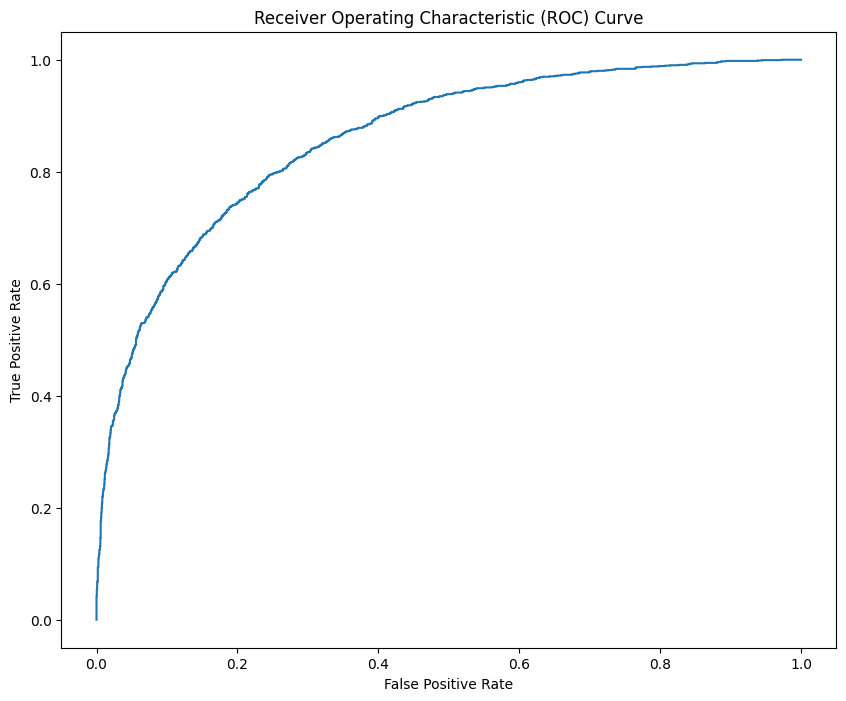

In [136]:
import matplotlib.pyplot as plt
# Assuming you have the true labels Y_test and predicted probabilities Test_prob
fpr, tpr, thresholds = roc_curve(Y_test.values.ravel(), Test_prob.values.ravel())

# Plotting the ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()


In [2]:
model = keras.models.load_model('model.h5')


In [35]:
ip = {'i want to die', 'this world is so fucking shit', 'i wish i was dead'}


In [36]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

# Define a function to preprocess the text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Join the tokens back into a string
    processed_text = ' '.join(tokens)
    
    return processed_text


In [37]:
labeldict ={'Feeling-bad-about-yourself-or-that-you-are-a-failure-or-have-let-yourself-or-your-family-down': 0,
            'Feeling-down-depressed-or-hopeless': 1, 
            'Feeling-tired-or-having-little-energy': 2, 
            'Little-interest-or-pleasure-in-doing ': 3,
            'Moving-or-speaking-so-slowly-that-other-people-could-have-noticed-Or-the-opposite-being-so-fidgety-or-restless-that-you-have-been-moving-around-a-lot-more-than-usual':4, 
            'Poor-appetite-or-overeating': 5, 
            'Thoughts-that-you-would-be-better-off-dead-or-of-hurting-yourself-in-some-way': 6, 
            'Trouble-concentrating-on-things-such-as-reading-the-newspaper-or-watching-television': 7, 
            'Trouble-falling-or-staying-asleep-or-sleeping-too-much': 8}

In [38]:
embedder = SentenceTransformer('google-bert/bert-base-uncased')
embedder.max_seq_length = 512
results = {}
for input_string in ip:
    # Preprocess the input string
    processed_input = preprocess_text(input_string)

    # Encode the processed input using the SentenceTransformer model
    embedded_input = embedder.encode([processed_input], show_progress_bar=False)

    # Make predictions for the input
    input_predictions = model.predict(embedded_input)
    input_predictions = pd.DataFrame(input_predictions)
    input_predictions = input_predictions.apply(lambda x: [1 if val >= 0.349802 else 0 for val in x])

    # Get the labels for input predictions
    input_predicted_labels = [(label, "yes" if input_predictions[value][0] == 1 else "no") for label, value in labeldict.items()]

    # Store the result in the dictionary
    results[input_string] = input_predicted_labels

# Ensure that all variables and functions are used correctly


No sentence-transformers model found with name google-bert/bert-base-uncased. Creating a new one with MEAN pooling.


In [40]:
results = {}
for input_string in ip:
    # Preprocess the input string
    processed_input = preprocess_text(input_string)

    # Encode the processed input using the SentenceTransformer model
    embedded_input = embedder.encode([processed_input], show_progress_bar=False)

    # Make predictions for the input
    input_predictions = model.predict(embedded_input)
    input_predictions = pd.DataFrame(input_predictions)
    input_predictions = input_predictions.apply(lambda x: [1 if val >= 0.349802 else 0 for val in x])

    # Get the labels for input predictions
    input_predicted_labels = [(label, "yes" if input_predictions[value][0] == 1 else "no") for label, value in labeldict.items()]

    # Store the result in the dictionary
    results[input_string] = input_predicted_labels

# Ensure that all variables and functions are used correctly


1/1 [==============================] - 0s 31ms/step


In [42]:
print(results)

{'this world is so fucking shit': [('Feeling-bad-about-yourself-or-that-you-are-a-failure-or-have-let-yourself-or-your-family-down', 'yes'), ('Feeling-down-depressed-or-hopeless', 'yes'), ('Feeling-tired-or-having-little-energy', 'no'), ('Little-interest-or-pleasure-in-doing ', 'no'), ('Moving-or-speaking-so-slowly-that-other-people-could-have-noticed-Or-the-opposite-being-so-fidgety-or-restless-that-you-have-been-moving-around-a-lot-more-than-usual', 'no'), ('Poor-appetite-or-overeating', 'no'), ('Thoughts-that-you-would-be-better-off-dead-or-of-hurting-yourself-in-some-way', 'no'), ('Trouble-concentrating-on-things-such-as-reading-the-newspaper-or-watching-television', 'no'), ('Trouble-falling-or-staying-asleep-or-sleeping-too-much', 'no')], 'i want to die': [('Feeling-bad-about-yourself-or-that-you-are-a-failure-or-have-let-yourself-or-your-family-down', 'yes'), ('Feeling-down-depressed-or-hopeless', 'no'), ('Feeling-tired-or-having-little-energy', 'yes'), ('Little-interest-or-pleas